# Prep

In [28]:
# Install Keras (for some reason, tensorflow.keras.models cannot be found...)
import sys
!{sys.executable} -m pip install keras


# Import analytics packages
import pandas as pd
import numpy as np
import pickle
from scipy import stats






import seaborn as sns
from pylab import rcParams
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8
import matplotlib.pyplot as plt
%matplotlib inline

%autosave 360

# Note thet line magic will fail if put as first line in datalab, due to "%" recognized as "%%". Ticket is here: https://github.com/googledatalab/datalab/issues/996



Autosaving every 360 seconds


In [4]:
# GCS IO - read the csv file from GCS bucket

import google.datalab.storage as storage
from io import BytesIO

myBucket = storage.Bucket('fraud-detection-jg')
object_list = myBucket.objects('eu-kaggle-pca-creditcard.csv')
# object_list = myBucket.objects(prefix='prefix_for_file_filter')

df_list = []

for object in object_list:
  %gcs read --object $object.uri --variable data  
#   df_list.append(pd.read_csv(BytesIO(data),sep='\t',header=None))
  df_list.append(pd.read_csv(BytesIO(data)))
  
concatenated_df = pd.concat(df_list, ignore_index=True)
df=concatenated_df
df.head()

# df2.to_csv('zh-en.tsv', index = False,header=None,sep='\t')
# !gsutil cp 'zh-en.tsv' 'gs://automl-jg/zh-en_none_header.tsv'

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Exploration

In [13]:
# len(concatenated_df)
print(df.shape)

print(df.isnull().values.any())


(284807, 31)
False


## Dependent Variable Distribution - Label Imbalance

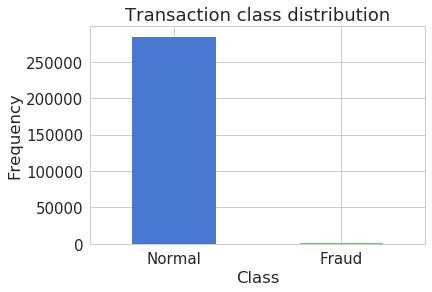

In [16]:

count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")

LABELS = ["Normal", "Fraud"]
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");
# Note that the semi-column here is needed for chart annotations to be correctly displayed


In [18]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]
print(frauds.shape)
print(normal.shape)

(492, 31)
(284315, 31)


In [19]:
frauds.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [20]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

## Indepent variable Distribution
Due to confidential reasion, the dataset only come with two columns - time and amount being the original attributes left, while all other personal  identification related attributes are all the transformed data by PCA.

## Amount per transaction by class

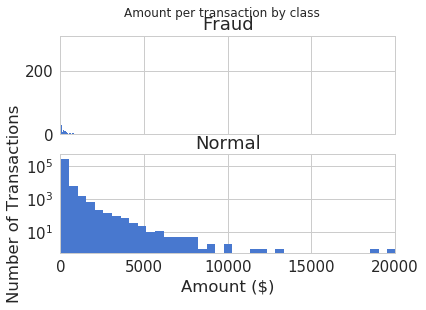

In [21]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

## Time of transaction by class

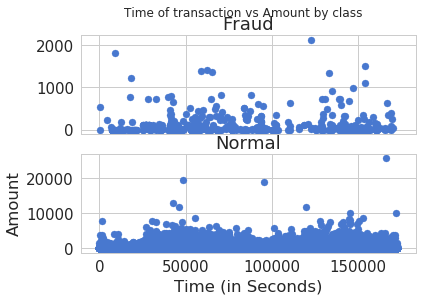

In [22]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

# Pre-processing

## Drop irrevelent features 
Per the findings from previous data exploration section, we will drop the Time column (not going to use it) 
## Noralmization
We will use the scikit’s StandardScaler on the Amount. The scaler removes the mean and scales the values to unit variance.

In [26]:
from sklearn.preprocessing import StandardScaler
data = df.drop(['Time'], axis=1)
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,0


## Training, testing data split
- train the auto-encoder model on the normal transactions only.
- split the data for training and test on a 80-20 basis.

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)

# the training of the auto-encoder model is on the normal transactions only, so we will remove the fraud data records and also the class the column
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

# split x,y columns on test dataset 
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)



# Build the model

Our Autoencoder uses 4 fully connected layers with 14, 7, 7 and 29 neurons respectively. The first two layers are used for our encoder, the last two go for the decoder. Additionally, L1 regularization will be used during training.

In [34]:
# transform from pandas table to arrays for later using Input modeule of Keras
X_train.values
print(X_train.shape)

X_test = X_test.values
print(X_test.shape)


(227451, 29)
(56962, 29)


In [36]:
import tensorflow as tf

## create tf session and register Keras - not for this case
# sess = tf.Session()
# from keras import backend as K
# K.set_session(sess)

from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

RANDOM_SEED = 42

In [45]:
input_dim = X_train.shape[1]
# X_train.shape[1] is 29

In [47]:

input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)


encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)

decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)


autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])


- train our model for 100 epochs with a batch size of 32 samples 
- save the best performing model to a file by the ModelCheckpoint provided by Keras
- the training progress will be exported in a format that TensorBoard understands.

In [48]:
nb_epoch = 100
batch_size = 32

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)

tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Train on 227451 samples, validate on 56962 samples
Epoch 1/100
227451/227451 [==============================] - 12s 53us/step - loss: 0.8194 - acc: 0.5738 - val_loss: 0.7871 - val_acc: 0.6635
Epoch 2/100
227451/227451 [==============================] - 11s 50us/step - loss: 0.7437 - acc: 0.6755 - val_loss: 0.7651 - val_acc: 0.6839
Epoch 3/100
227451/227451 [==============================] - 11s 48us/step - loss: 0.7315 - acc: 0.6917 - val_loss: 0.7588 - val_acc: 0.6992
Epoch 4/100
227451/227451 [==============================] - 11s 47us/step - loss: 0.7267 - acc: 0.6995 - val_loss: 0.7569 - val_acc: 0.7067
Epoch 5/100
227451/227451 [==============================] - 11s 48us/step - loss: 0.7243 - acc: 0.7015 - val_loss: 0.7557 - val_acc: 0.7079
Epoch 6/100
227451/227451 [==============================] - 11s 47us/step - loss: 0.7232 - acc: 0.7019 - val_loss: 0.7577 - val_acc: 0.6951
Epoch 7/100
227451/227451 [==============================] - 11s 47us/step - loss: 0.7224 - acc: 0.7027

227451/227451 [==============================] - 11s 48us/step - loss: 0.7100 - acc: 0.7190 - val_loss: 0.7429 - val_acc: 0.7255
Epoch 59/100
227451/227451 [==============================] - 11s 48us/step - loss: 0.7096 - acc: 0.7201 - val_loss: 0.7518 - val_acc: 0.7079
Epoch 60/100
227451/227451 [==============================] - 11s 48us/step - loss: 0.7095 - acc: 0.7190 - val_loss: 0.7438 - val_acc: 0.7148
Epoch 61/100
227451/227451 [==============================] - 11s 48us/step - loss: 0.7097 - acc: 0.7200 - val_loss: 0.7418 - val_acc: 0.7157
Epoch 62/100
227451/227451 [==============================] - 11s 48us/step - loss: 0.7095 - acc: 0.7212 - val_loss: 0.7419 - val_acc: 0.7262
Epoch 63/100
227451/227451 [==============================] - 11s 47us/step - loss: 0.7096 - acc: 0.7205 - val_loss: 0.7439 - val_acc: 0.7233
Epoch 64/100
227451/227451 [==============================] - 11s 48us/step - loss: 0.7096 - acc: 0.7202 - val_loss: 0.7415 - val_acc: 0.7208
Epoch 65/100
227451

In [50]:
# load the saved model (just to check if it works)
autoencoder = load_model('model.h5')
autoencoder